# Image recognition using CNN features, RF and XGBoosting

In [ ]:
!pip install xgboost==1.6.1

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
import matplotlib
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import scipy.stats


In [ ]:
# Import dataset

digits = datasets.load_digits()
dir(digits)

['DESCR', 'data', 'feature_names', 'frame', 'images', 'target', 'target_names']

## Generate Convoluted Features

In [ ]:
def zero_padding(imgs):
    """
    Takes an array and pads it with 2 zeroes on each side (left/right and up/down)
    to create a resulting array with Same Padding
    """

    padded_imgs = []
    
    # Loop through each img to apply padding
    for i in range(len(imgs)):
        padded_img = np.pad(imgs[i], [(2, ), (2, )], mode='constant')
        padded_imgs.append(padded_img)
    
    return padded_imgs

In [ ]:
class conv_layer_1:

    def __init__(self, img, conv_filter):

        self.img = img
        self.conv_filter = conv_filter
        
    def conv_(self, img, conv_filter):
        """
        Apply edge convolutional feature - 
        Steps:
        Step 1: Pick the filter, here we have used 3*3 vertical filter
        Step 2: Multiple the filter on selected region of image that is 3*3
        Step 3: Sumup the result of Step 2
        Step 4: Save the new image
        """
        
        self.fil_sz = conv_filter.shape[1]
        self.result = np.zeros((img.shape))

        for r in np.uint16(np.arange(self.fil_sz/2.0, img.shape[0]-self.fil_sz/2.0+1)):

            for c in np.uint16(np.arange(self.fil_sz/2.0, img.shape[1]-self.fil_sz/2.0+1)):

                # Selecting the current region for kernel and matrix multiplication
                curr_rg = img[int(r-(np.floor(self.fil_sz/2.0))) : int(r+(np.ceil(self.fil_sz/2.0))), 
                                   int(c-(np.floor(self.fil_sz/2.0))) : int(c+(np.ceil(self.fil_sz/2.0)))]

                #Element-wise multiplication between the current region and the filter.
                self.curr_result = curr_rg * conv_filter
                

                self.conv_sum = np.sum(self.curr_result) #Summing the result of multiplication.
                

                self.result[r, c] = self.conv_sum #Saving the summation in the convolution layer feature map.

        #Clipping the outliers of the result matrix.
        final_result = self.result[int(self.fil_sz/2.0):self.result.shape[0]-int(self.fil_sz/2.0), 
                              int(self.fil_sz/2.0):self.result.shape[1]-int(self.fil_sz/2.0)]
        
        return final_result
    
    def conv_layer_1_func(self, conv_filter, imgs):
        """
        Apply conv function to all images and creates a dataframe.
        """

        # Call the function
        res_img_arr = []
        
        for img in imgs:
            res_img = self.conv_(img, conv_filter)
            res_img_arr.append(res_img)
            # res_img = self.conv(img, conv_filter)
            # res_img_arr.append(res_img[:,:,-1])

        # Change res to numpy array
        res_img_arr_np = np.array(res_img_arr)

        # flatten the images
        n_samples = len(res_img_arr_np)
        data_filtered = res_img_arr_np.reshape((n_samples, -1))

        # Convert to DF
        df_ver = pd.DataFrame(data_filtered).add_prefix('ver_')

        return df_ver, res_img_arr_np


In [ ]:
class conv_layer_2_3:
    
    def __init__(self, img, pool_size, stride):
        
        self.img = img
        self.pool_size = pool_size
        self.stride = stride
        
    def get_pools(self, img: np.array, pool_size: int, stride: int) -> np.array:
        """
        Pass in image and return multiple pools based on pool size and stride size
        """

        # To store each individual pool in the list
        self.each_pool = []

        # Iterate over all row blocks 
        for i in np.arange(img.shape[0], step=stride):
            
            # Iterate over all column blocks 
            for j in np.arange(img.shape[1], step=stride):
            
                # Extract the current pool
                self.mat = img[i:i+pool_size, j:j+pool_size]

                # Ensure each matrix has the shape identical to the pool size
                if self.mat.shape == (pool_size, pool_size):
                    
                    # Append to the list of pools
                    self.each_pool.append(self.mat)       
        
        # Return all pools as a Numpy array
        return np.array(self.each_pool)
    
    def max_pooling(self, pools: np.array) -> np.array:
        """
        Apply max pooling (highest #) convolutional filter
        """

        # Total number of pools for each image
        self.num_pools = pools.shape[0]
        
        # Shape of the matrix after pooling - Square root of the number of pools
        # Cast it to int, as Numpy will return it as float
        # For example --> np.sqrt(16) = 4.0 --> int(4.0) = 4
        
        self.target_shape = (int(np.sqrt(self.num_pools)), int(np.sqrt(self.num_pools)))
        # To store the max values
        self.pooled = []

        # Iterate over all pools
        for pool in pools:
            
            # Append the max value only
            self.pooled.append(np.max(pool))

        # Reshape to target shape
        return np.array(self.pooled).reshape(self.target_shape)
    
    def min_pooling(self, pools: np.array) -> np.array:
        """
        Apply min pooling (lowest #) convolutional filter
        """

        # Total number of pools for each image
        self.num_pools = pools.shape[0]
       
        # Shape of the matrix after pooling - Square root of the number of pools
        # Cast it to int, as Numpy will return it as float
        # For example -> np.sqrt(16) = 4.0 -> int(4.0) = 4
        
        self.target_shape = (int(np.sqrt(self.num_pools)), int(np.sqrt(self.num_pools)))
        # To store the min values
        self.pooled = []

        # Iterate over all pools
        for pool in pools:
            
            # Append the min value only
            self.pooled.append(np.min(pool))

        # Reshape to target shape
        return np.array(self.pooled).reshape(self.target_shape)
    
    def conv_layer_2_func(self, imgs, pool_size, stride):
        """
        Apply max and min function to all images and create dataframes.
        """

        pool = []
        for img in imgs:
            pool_arr = self.get_pools(img=img, pool_size=2, stride=2)
            pool.append(pool_arr)

        np_pool=np.array(pool)

        max_pool_arr = []
        for pool in np_pool:
            max_pool_arr_data = self.max_pooling(pools=pool)
            max_pool_arr.append(max_pool_arr_data)

        np_max_pool=np.array(max_pool_arr)

        min_pool_arr = []
        for pool in np_pool:
            min_pool_arr_data = self.min_pooling(pools=pool)
            min_pool_arr.append(min_pool_arr_data)

        np_min_pool=np.array(min_pool_arr)

        # flatten the max pool images
        n_samples = len(np_max_pool)
        np_max_pool_fl = np_max_pool.reshape((n_samples, -1))

        # max pool df
        df_max = pd.DataFrame(np_max_pool_fl).add_prefix('max_')

        # flatten the min pool images
        n_samples = len(np_min_pool)
        np_min_pool_fl = np_min_pool.reshape((n_samples, -1))

        # max pool df
        df_min = pd.DataFrame(np_min_pool_fl).add_prefix('min_')

        return df_min, df_max, np_max_pool, np_min_pool

In [ ]:
# Call Zero Padding

padded_images = zero_padding(digits.images)
imgs = padded_images

In [ ]:
# Shape of each padded image = 12x12
print('padded_images[0].shape =', padded_images[0].shape)

# Checking what our padded image looks like:
print(padded_images[0])

padded_images[0].shape = (12, 12)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  5. 13.  9.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  0.]
 [ 0.  0.  0.  3. 15.  2.  0. 11.  8.  0.  0.  0.]
 [ 0.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  0.]
 [ 0.  0.  0.  5.  8.  0.  0.  9.  8.  0.  0.  0.]
 [ 0.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  0.]
 [ 0.  0.  0.  2. 14.  5. 10. 12.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  6. 13. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


### Convolution Layer 1 - Vertical edge filter (3*3)

In [ ]:
# Create a NumPy array of zeroes 1 layer deep, 3x3 area
v_filter = np.zeros((1,3,3))

# Replace the zero array with our vertical edge filter
v_filter[0, :, :] = np.array([[[-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1]]])

# Instantiate Convolutional Layer 1 class
c_l1 = conv_layer_1(img = imgs, conv_filter = v_filter)

# Saving Vertical Edge DF
df_ver, ver_imgs = c_l1.conv_layer_1_func(conv_filter = v_filter, imgs = imgs)

### Convolution Layers 2, 3 - Min, Max Pooling

In [ ]:
# Instantiate Convolutional Layer 2, 3 class
c_l2 = conv_layer_2_3(imgs, pool_size=2, stride=2)

# Saving Min, Max DF
df_min, df_max, max_imgs, min_imgs = c_l2.conv_layer_2_func(imgs, pool_size=2, stride=2)

#### Plot one image for each convoluted layer

Text(0.5, 1.0, 'Padded-Image')

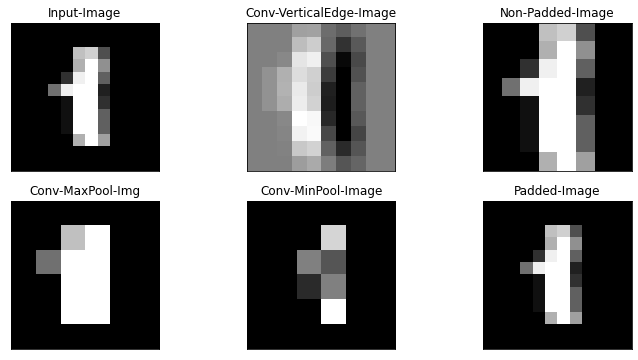

In [ ]:
# Input Image - Picked 1 digit for example purposes
fig1, ax1 = matplotlib.pyplot.subplots(nrows=2, ncols=3, figsize=(12, 6))
ax1[0, 0].imshow(padded_images[1]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("Input-Image")

# Layer 1 - vertical edge filter
ax1[0, 1].imshow(ver_imgs[1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("Conv-VerticalEdge-Image")

# Layer 1 - Non padded image
ax1[0, 2].imshow(digits.images[1]).set_cmap("gray")
ax1[0, 2].get_xaxis().set_ticks([])
ax1[0, 2].get_yaxis().set_ticks([])
ax1[0, 2].set_title("Non-Padded-Image")

# Layer 2 - max pooling
ax1[1, 0].imshow(max_imgs[1]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("Conv-MaxPool-Img")

# Layer 2 - min pooling
ax1[1, 1].imshow(min_imgs[1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("Conv-MinPool-Image")

# Layer 2 - Padded Image
ax1[1, 2].imshow(padded_images[1]).set_cmap("gray")
ax1[1, 2].get_xaxis().set_ticks([])
ax1[1, 2].get_yaxis().set_ticks([])
ax1[1, 2].set_title("Padded-Image")

#### Flatten the images and create dataframe with all merged layers

In [ ]:
# Flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
df = pd.DataFrame(data)
df = df.add_prefix('pix_')

# Concat all the layers
final_df = pd.concat([df, df_ver, df_min, df_max], axis=1)

# Add target to the end of the DF
final_df['target'] = pd.DataFrame(digits.target)
final_df.head()

,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,pix_9,...,max_27,max_28,max_29,max_30,max_31,max_32,max_33,max_34,max_35,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,16.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,14.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


### Col sections
```
DIM'S   AREA    COL #'S     LAYER           DESCRIPTION
8*8     = 64    = 0-63      = 1st layer     = original digits
10*10   = 100   = 64-164    = 2nd layer     = vertical edge
6*6     = 36    = 165-200   = 3rd layer     = min pooling
6*6     = 36    = 201-237   = 4th layer     = max pooling
```

In [ ]:
Total_features= 64 + 100 + 36 + 36 
print(f"Total features = {Total_features} and there's a few more we added on the right of the DF like target")

Total features = 236 and there's a few more we added on the right of the DF like target


#### Split the data

In [ ]:
# Split the data 

df_train, df_test = train_test_split(final_df, 
                                    test_size = 0.3, 
                                    random_state = 66, 
                                    stratify = final_df['target'])

In [ ]:
features = df_train.columns[:-1] 
target = 'target'
X_train = df_train[features]
#y_train = df_test[features]

## Apply RandomForest Classifier and a XGBClassifier

### RandomForestClassifier

In [ ]:
# Initialize Random Forest (RF) model creation
rfc = RandomForestClassifier()

# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(20, 200, num = 10)]
max_depth.append(None)

# create random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth
}

# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, 
                                param_distributions = random_grid, 
                                n_iter = 100, 
                                cv = 3, 
                                verbose = 2, 
                                random_state = 66, 
                                n_jobs = -1) # -1 indicates to use the computer's maximum available CPU threads to run

# Fit the model
rfc_random.fit(X_train, df_train[target])

# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 800, 'max_features': 'sqrt', 'max_depth': 180}


In [ ]:
# RF best params:
#{'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 120}

rfc_model = RandomForestClassifier(**(rfc_random.best_params_))

#rfc_model = RandomForestClassifier(n_estimators=1000, max_depth=120, max_features= 'auto')

# fit the model
rfc_model.fit(X_train, df_train[target])

RandomForestClassifier(max_depth=180, max_features='sqrt', n_estimators=800)

### XGBClassifier

In [ ]:
clf_xgb = xgb.XGBClassifier()

param_dist = {'n_estimators':       [200, 230, 460], # number of trees
              'learning_rate':      scipy.stats.uniform(0.01, 0.50),
              'max_depth':          [3, 4, 5, 6, 7, 8, 9],
              'min_child_weight':   [1, 2, 3, 4],
              # WARNING: THE BELOW ONES MAKE IT WORSE
              #'subsample':          scipy.stats.uniform(0.3, 0.6),
              #'colsample_bytree':   scipy.stats.uniform(0.5, 0.4),
              #'num_parallel_tree':  [2],
              #'gamma':              [0.3],
              #'alpha':              [0.5]
             }

xgb_cv = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = 3,  
                         n_iter = 10, # will use 30 fits
                         error_score = 0, 
                         verbose = 3, 
                         #random_state = 66,
                         n_jobs = -1) # -1 indicates to use the computer's maximum available CPU threads to run

xgb_cv.fit(X_train, df_train[target])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, error_score=0,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=

In [ ]:
xgb_cv.best_params_
# xgb_best_params = {'learning_rate': 0.35902233602231903,
#  'max_depth': 3,
#  'min_child_weight': 2,
#  'n_estimators': 230}

{'learning_rate': 0.1096040339727528,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 460}

In [ ]:
# Running the model on best parameters 

clf_model = xgb.XGBClassifier(**(xgb_cv.best_params_))

#clf_model = xgb.XGBClassifier(**xgb_best_params)

# fit the model
clf_model.fit(X_train, df_train[target])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1096040339727528, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=460, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, ...)

## Model Evaluation

### Evaluate RF
- Confusion Matrix is used to evaluate the models

Our model has multiple different digits (classes) which may need to be evaluated individually. This would call for a Confusion Matrix evaluation approach to see which ones are doing better and which ones are not. 

#### Compute the precision.

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The best value is 1 and the worst value is 0.

#### Compute the recall.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0.

After applying a stratified split, we could see that each digit had roughly the same # of samples as the others. While this is a very even distribution of our data and actually gave better results than when leaving it up to random chance how the train test split would allocate each digit, there were some digits that had more error than others. These may have benefitted from additional samples of those specific digits for training. For example, the #9 had quite a few errors. However, in raw #'s the errors are in the range of 0 - 4 per digit, which is not that bad and explains why we can't really improve the average accuracy much past 98%. Each incorrect prediction is already a roughly 2% hit to accuracy. Most of the digits can be predicted with nearly 100% accuracy otherwise, which we can see on the Confusion Matrix results, but a few digits consistently have errors across all models and recall and precision measures.

#### NOTES:
[SOURCE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score]
    

In [ ]:
def evaluate_model(model_pointer, y_true, y):
    """
    Evaluate the models 
    """
    y_pred = model_pointer.predict(y)
    
    # print(f'Precision score = {precision_score(y_true, y_pred, average="weighted")}')
    # print(f'Recall score = {recall_score(y_true, y_pred, average="weighted")}')
    
    # Classification report
    print(
        f"\nClassification report for classifier {model_pointer}:\n"
        f"{metrics.classification_report(y_true, y_pred)}\n"
    )
    
    # Confusion matrix 
    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    disp.figure_.suptitle("Confusion Matrix")
    print(f"Confusion matrix:\n{disp.confusion_matrix}")

    plt.show()
    
    return y_pred


Classification report for classifier RandomForestClassifier(max_depth=180, max_features='sqrt', n_estimators=800):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.95      1.00      0.97        55
           2       1.00      1.00      1.00        53
           3       1.00      0.95      0.97        55
           4       1.00      0.98      0.99        54
           5       0.96      0.96      0.96        55
           6       1.00      1.00      1.00        54
           7       0.96      0.98      0.97        54
           8       1.00      0.98      0.99        52
           9       0.95      0.96      0.95        54

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540


Confusion matrix:
[[54  0  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  0  0]
 [ 0  0 53  0  0  0  0  0  0  0]
 [ 0  0

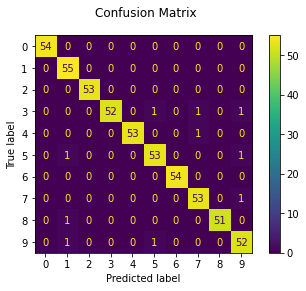

In [ ]:
# Evaluate function call for RF
rfc_pred = evaluate_model(rfc_model, df_test[target], df_test[features])


Classification report for classifier XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1096040339727528, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=460, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, ...):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        54
           1       0.95      0.96      0.95        55
           2       0.98      0.98      0.98        53
          

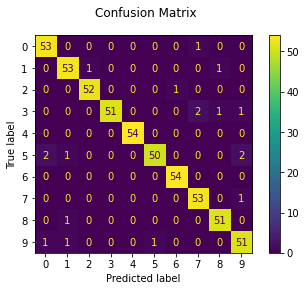

In [ ]:
## Evaluate function call for  XGBoost
clf_pred = evaluate_model(clf_model, df_test[target], df_test[features])

`Compare the model performance of RF and Xgboosting`

### RF vs XGBoost

### RF 
- the best
- generally better when there are more classifiers (in our case digits)
- hyperparameter tuning on RF worked pretty well with multiple percentage point increases over the base RF which didn't have any hypertuning or convoluted features
- RF can be improved with additional hyperparameters, but RandomizedSearchCV needed to search all possibilities concurrently eventually exceeds what our machines and DeepNote can handle and we had to scale back and attempt it in smaller arrays and then check again. Attempting too many hyperparameters at once either crashes or takes hours to run
- Since the digit distribution is fairly even, RF biasing one pathway over others is less of a concern in this case (which could have been an advantage for XGBoost if it was the other way around)

### XGBoost
- worse
- SHOULD work better with fewer classifiers (here we have 10), but we were expecting that the 10 here would be considered "few" already and work well, but it didn't
- the advantage is that it's quick and learns on its own but hyperparameter tuning doesn't seem to change the final result much, even with massive hyperparameter changes and hours of RandomdizedSearchCV, it only changes within a narrow range and actually most of what we tried only made it worst. The XGBoost results without any tuning are pretty much near the maximum accuracy we can achieve with it even after days of tuning
- Since XGBoost's hyperparameters apply mainly to the 1st tree and afterwards it learns to adjust itself, the effect of hyperparameter tuning is likely nearly neglible as long as it's roughly in the right neighborhood
- XGBoost might just not be an optimal method or approach when attempting to recognize the images of handwritten digits, the hyperparameters seem to be designed with massively large distributed computing in mind, multiple harddrives, multiple CPU's, and presumably incredibly large datasets, of which ours are probably considered small in comparison and weak for computing strength 

## Printing best and worst predicted images

In [ ]:
# Add predictions back to our DF for correct/wrong predictions
df_test['rfc_pred'] = rfc_pred
df_test['xg_pred'] = clf_pred

# Find out TRUE (correct) or FALSE (incorrect) identification 
df_test['rfc_false'] = df_test[target] == df_test['rfc_pred']
df_test['xg_false'] = df_test[target] == df_test['xg_pred']

In [ ]:
# Pull out original layer images columns
img_col = df_test.columns[df_test.columns.str.contains('pix_')|\
                          df_test.columns.str.contains('target')|\
                          df_test.columns.str.contains('rfc_')|\
                          df_test.columns.str.contains('xg_')]

img_col1 = df_test.columns[df_test.columns.str.contains('pix_')]

In [ ]:
# Reshape array into 2D images
def conver_2d_imgs(df, cols, m, n):
    
    images = []
    for i in range(len(df)):
        img = df[cols].loc[i].ravel().reshape(m, n)
        images.append(img)
        
    return images

In [ ]:
def plot_images(predictions, images, target, w, h):
    """
    Plot images via matplotlib
    """

    if len(predictions)>0:
        _, axes = plt.subplots(nrows=1, ncols=len(predictions), figsize=(w, h))
        for ax, image, prediction, target in zip(axes, images, predictions, target):
            ax.set_axis_off()
            ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
            ax.set_title(f'''Pred: {prediction}
            Tar: {target}''')
    else:
        print("No best images predication compared to other model")

In [ ]:
def filter_df(df, condition, req_col, req_col1, m, n):
    """
    Filter the DF based on pass/fail conditions
    """
    
    # All images pull based on condition
    df_false = df.loc[condition]

    if (len(df_false)==0):
        return '0', '0'

    else:
        # Reset_index
        df_img = df_false[req_col].reset_index().drop('index', axis=1)

        # Create images
        images_2d = conver_2d_imgs(df_img, req_col1, m, n)
        
        return images_2d, df_img

In [ ]:
# RF
# RF false identification 
rf_img_f, rf_df_f = filter_df(df_test, df_test['rfc_false'] == False, img_col, img_col1, 8, 8)

# RF best identification over XGBoost
rf_img_b, rf_df_b = filter_df(df_test, (df_test['xg_false'] == False) & (df_test['rfc_false'] == True), img_col, img_col1, 8, 8)

# XGBoost
# XG false identification 
xg_img_f, xg_df_f = filter_df(df_test, df_test['xg_false'] == False, img_col, img_col1, 8, 8)

# XG best identification over RF
xg_img_b, xg_df_b = filter_df(df_test, (df_test['rfc_false'] == False) & (df_test['xg_false'] == True)
                              , img_col, img_col1, 8, 8)

#### False identified images by RF

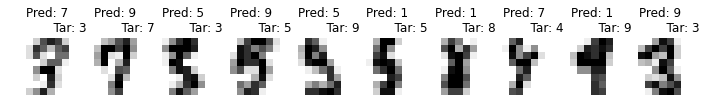

In [ ]:
# Falsely identified images

plot_images(rf_df_f['rfc_pred'], rf_img_f, rf_df_f['target'], 12, 7)

#### Best predictions done by RF

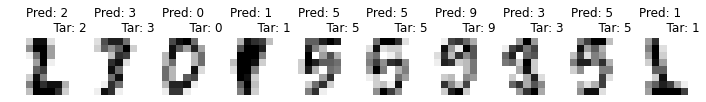

In [ ]:
# Best predictions done by RF which is failed by XGBoost

if len(rf_df_b) != 1:
    plot_images(rf_df_b['rfc_pred'], rf_img_b, rf_df_b['target'], 12, 7)
else:
    print('No best images prediction compared to the other model')

#### False identified images by XGBoost

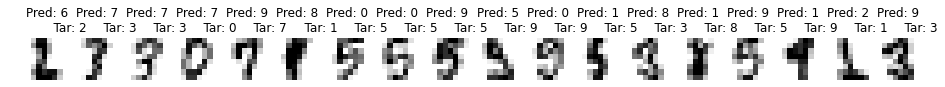

In [ ]:
# False identified images

plot_images(xg_df_f['xg_pred'], xg_img_f, xg_df_f['target'], 16, 7)

#### Best predictions done by XGBoost

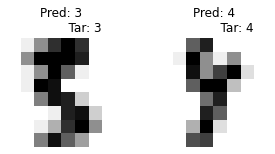

In [ ]:
# Best predictions done by XGBoost which has failed by RF
if len(xg_df_b) != 1:
    plot_images(xg_df_b['xg_pred'], xg_img_b, xg_df_b['target'], 5, 2)
else:
    print('No best images predication compared to other model')

`- what makes the models fail and how they can improve.`

If we look at the printouts of digits (please see above code blocks) that failed to predict correctly, we can see that the reason many of them ended up there is pretty much bad handwriting... Overlapping parts, missing gaps, and similarities to other digits abound. As a human, I would have trouble identifying some of these. 

If you look at the F1 scores from the Confusion Matrices (this combines the Precision and Recall scores) you can see the #9 is consistently the worst performer across both RF and XGBoost, as well as both Recall and Precision measurements. This backs up what we see in the printouts of the failed predictions. The digit #9 is confused with: 1, 3, 5, 7. This would definitely benefit from having more samples to train on. In 2nd and 3rd place for worst would be digits #3 and #5. 

If there's a lot of errors in 1 particular digit, it may need more training data there to learn it better. Ideally, this would be the best solution: MORE DATA! Specifically for the digits: 9, 5, 3. In the same vien, higher quality data that is better resolution than 8x8 pixels would probably show spaces inside digits better and be less likely to be mixed up with another digit.

However, in leiu of generating additional data, what can we do here with our current existing models? 
- K-folds: increase the CV from 3 to something higher like 5, we've tested this before and gotten improved results
- RF: run with a much larger array at the same time in RandomizedSearchCV to identify a wider spectrum of possible answers, however, we've also attempted many variations of this and mostly settled on running it with smaller arrays of hyperparameters due to DeepNote crashing, or our laptops crashing, or running for many hours only to produce no output and possibly having lost everything due to RAM running out. We also managed to get several different optimized hyperparameter combinations here, which I suspect is due to local minimums that we see as a result of a narrow array. But there is probably room to improve this further if we had more capable hardware that could run more combinations at once
- XGBoost: probably should not be used here but in order to see advantages over RF, we'd probably want to add in more data for the failing identifications (#'s 9, 5, 3) and thus create an uneven class balance of digits, while also increasing the dataset size. This should probably start to improve over RF, but also taking advantage of the computing resources better in the hyperparameters would probably have better outcomes than other hyperparameter tuning as a result of the way XGBoost works 
- Extra convolutional layers: I think that we had included a Horizontal edge convlutional feature, then maybe it would be able to figure out digits better. Along the same line of reasoning, probably including edges that are at angles, like 45 degrees, would also help improve the accuracy. If there is a way to apply a circular filter as well, this may help for digits like 0, 5, 8, 9. 